
Clone Github


In [1]:
!git clone https://github.com/impact-moe/impact-classification
%cd './impact-classification' 

fatal: destination path 'impact-classification' already exists and is not an empty directory.
/content/impact-classification


Imports

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D,Reshape, Permute
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import keras.utils
from scipy import signal
import importlib

import os 
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance
from IPython.display import display
from matplotlib import cm

Load in training data

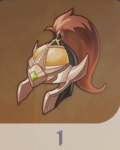

tenacity-of-the-millelith-circlet-5


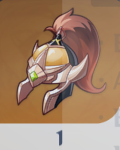

tenacity-of-the-millelith-circlet-5


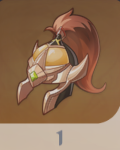

tenacity-of-the-millelith-circlet-5


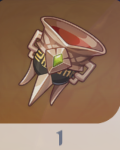

tenacity-of-the-millelith-goblet-5


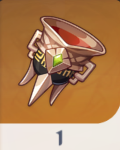

tenacity-of-the-millelith-goblet-5


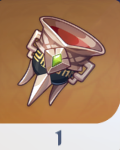

tenacity-of-the-millelith-goblet-5


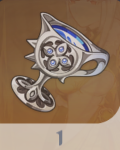

pale-flame-goblet-5


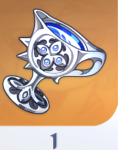

pale-flame-goblet-5


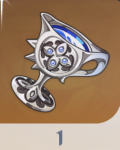

pale-flame-goblet-5


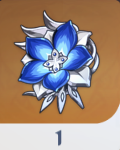

pale-flame-flower-5


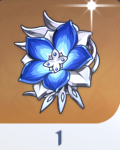

pale-flame-flower-5


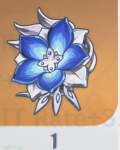

pale-flame-flower-5


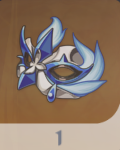

pale-flame-circlet-5


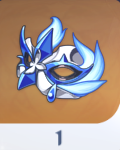

pale-flame-circlet-5


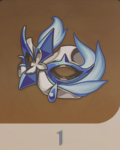

pale-flame-circlet-5


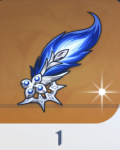

pale-flame-plume-5


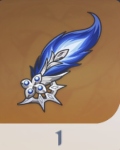

pale-flame-plume-5


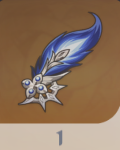

pale-flame-plume-5


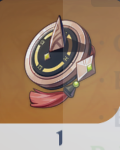

tenacity-of-the-millelith-sands-5


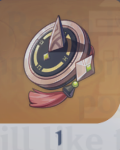

tenacity-of-the-millelith-sands-5


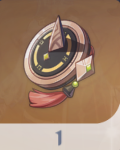

tenacity-of-the-millelith-sands-5


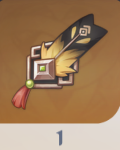

tenacity-of-the-millelith-plume-5


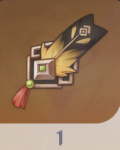

tenacity-of-the-millelith-plume-5


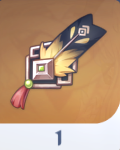

tenacity-of-the-millelith-plume-5


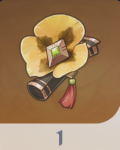

tenacity-of-the-millelith-flower-5


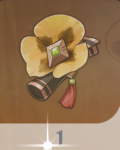

tenacity-of-the-millelith-flower-5


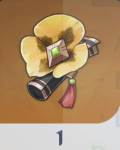

tenacity-of-the-millelith-flower-5


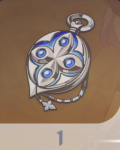

pale-flame-sands-5


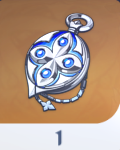

pale-flame-sands-5


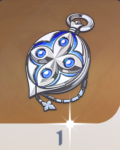

pale-flame-sands-5


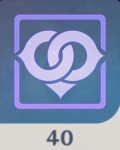

companionship-exp


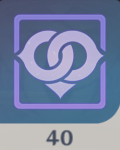

companionship-exp


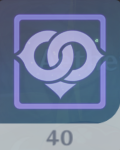

companionship-exp


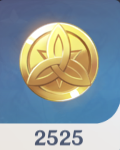

mora


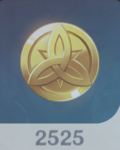

mora


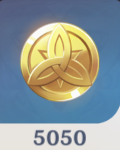

mora


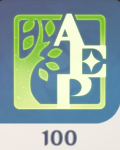

adventure-exp


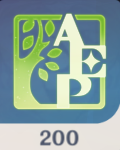

adventure-exp


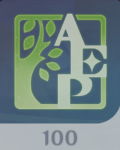

adventure-exp
(39, 150, 120, 4)
(72, 150, 120, 4)
{0: 'tenacity-of-the-millelith-circlet-5', 1: 'tenacity-of-the-millelith-goblet-5', 2: 'pale-flame-goblet-5', 3: 'pale-flame-flower-5', 4: 'pale-flame-circlet-5', 5: 'pale-flame-plume-5', 6: 'tenacity-of-the-millelith-sands-5', 7: 'tenacity-of-the-millelith-plume-5', 8: 'tenacity-of-the-millelith-flower-5', 9: 'pale-flame-sands-5', 10: 'companionship-exp', 11: 'mora', 12: 'adventure-exp'}


In [21]:

#get list of filenames
groups=['artifacts', 'general']#just hardcoded for now may change
path="./"
item_codes={}
item_num=0;
num_train=3
H,W = 150,120

X_train = []
y_train = []

X_val = []
y_val = []
#X_num_train = []

for folder in groups:
  _, items, _ = next(os.walk(path+folder))
  for item in items:
    item_codes[item_num]=item
    _, _, pics = next(os.walk(path+folder+"/"+item))
    i=0
    for pic in pics:
      with Image.open(path+folder+"/"+item+"/"+pic, 'r') as img:
        #crop images so they have uniform dimensions
        imgs=[]
        img = img.crop((0,0, W,H))
        imgs.append(img)
        imgs.append(img.filter(ImageFilter.BLUR)) #blur
        img_enhance = ImageEnhance.Brightness(img)
        imgs.append(img_enhance.enhance(.8)) #dark
        imgs.append(img_enhance.enhance(1.2)) #light

        #display first image of each item
        if (i < num_train):#i==1:
          for c in range(1):
            display(imgs[c])
          print(item)
        #num = img.crop((0,int(H*12.5/15), W,int(H)))  
        for c in range(1):
          if (i < num_train):
            X_train.append(np.array(imgs[c]))
            y_train.append(item_num)
          else:
            X_val.append(np.array(imgs[c]))
            y_val.append(item_num)

        #X_num_train.append(np.array(num))
      i+=1

    item_num+=1;

#output for testing purposes will quickly become incomprehensible 
X_train = np.array(X_train)
X_val = np.array(X_val)
print(X_train.shape)
print(X_val.shape)
y_train = tf.keras.utils.to_categorical(y_train, item_num)
y_val = tf.keras.utils.to_categorical(y_val, item_num)
print(item_codes)

Same but for Test data

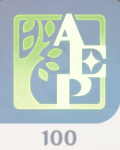

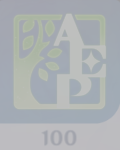

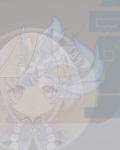

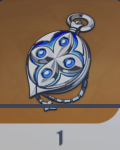

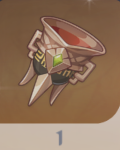

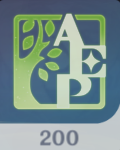

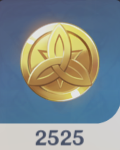

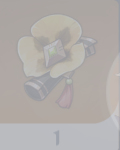

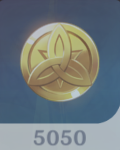

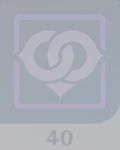

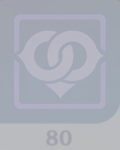

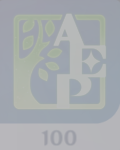

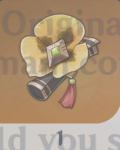

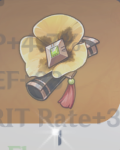

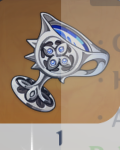

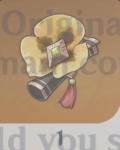

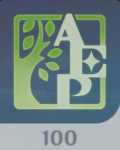

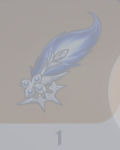

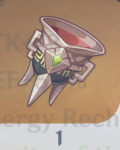

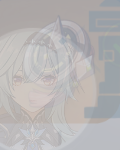

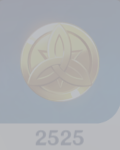

In [22]:
test_loc = 'test-images'
_, items, test_imgs = next(os.walk(path+test_loc))
X_test = []
#X_num_test = []

flag=True
i=0
for img in test_imgs:
  if i>100:
    break
  else:
    i+=1
  with Image.open(path+test_loc+'/'+img, 'r') as img:
    img = img.crop((0,0, W,H))
    display(img)
    num = img.crop((0,int(H*12.5/15), W,int(H)))  
    X_test.append(np.array(img))
    #X_num_test.append(np.array(num))

X_test=np.array(X_test)
#X_num_test=np.array(X_num_test)

Create model

In [26]:
# Model parameters
dropout = 0.50
lr = 1e-3
epochs = 100 #small for now will change when needed

#Building the model

cnn_models = []
for i in range(1):
  cnn_models.append(Sequential())
i=0;
# First block of conv.
cnn_models[i].add(Conv2D(filters=52, kernel_size=(3,3), input_shape=(H,W,4), activation='relu'))
cnn_models[i].add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_models[i].add(BatchNormalization())
cnn_models[i].add(Dropout(dropout))

# # Second block of conv.
cnn_models[i].add(Conv2D(filters=26, kernel_size=(2,2), activation='relu'))
cnn_models[i].add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_models[i].add(BatchNormalization())
cnn_models[i].add(Dropout(dropout))

# # third block of conv.
cnn_models[i].add(Conv2D(filters=13, kernel_size=(2,2), activation='relu'))
cnn_models[i].add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_models[i].add(BatchNormalization())
cnn_models[i].add(Dropout(dropout))


# FC layer
cnn_models[i].add(Flatten())
cnn_models[i].add(Dense(item_num, activation='softmax'))




  # Defining the optimizer
  # optimizer = keras.optimizers.Adam(learning_rate=lr)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
  
  # checkpoint_filepath = "/content/drive/Shareddrives/EE147/cnn_checkpoint/paperCNN"
  # # checkpoint = keras.callbacks.ModelCheckpoint(
  # #       #checkpoint_filepath,
  # #       monitor="val_accuracy",
  # #       save_best_only=True,
  # #       save_weights_only=True,)
  
lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=8, verbose=False)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=False, patience=64)

callbacks=[lr_decay, early_stopping]

# Compiling the model
cnn_models[i].compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

cnn_models[i].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 118, 52)      1924      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 59, 52)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 74, 59, 52)        208       
_________________________________________________________________
dropout_12 (Dropout)         (None, 74, 59, 52)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 73, 58, 26)        5434      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 29, 26)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 37, 29, 26)       

Train model

In [27]:

cnn_results = cnn_models[0].fit(X_train,
                            y_train,
                            batch_size=32,
                            epochs=epochs,
                            callbacks=callbacks,
                            validation_data=(X_val, y_val), verbose=True)

score = cnn_models[0].evaluate(X_train, y_train, verbose=0)[1]
print(f'Test accuracy of the CNN model:',score)

Epoch 1/100
2/2 [==============================] - 3s 1s/step - loss: 3.9317 - accuracy: 0.1271 - val_loss: 55.5233 - val_accuracy: 0.0556
Epoch 2/100
2/2 [==============================] - 2s 656ms/step - loss: 4.0710 - accuracy: 0.0550 - val_loss: 41.9777 - val_accuracy: 0.0556
Epoch 3/100
2/2 [==============================] - 2s 663ms/step - loss: 3.3721 - accuracy: 0.0996 - val_loss: 62.1365 - val_accuracy: 0.0556
Epoch 4/100
2/2 [==============================] - 2s 653ms/step - loss: 2.6346 - accuracy: 0.1993 - val_loss: 43.6395 - val_accuracy: 0.0556
Epoch 5/100
2/2 [==============================] - 2s 677ms/step - loss: 2.4942 - accuracy: 0.2818 - val_loss: 31.6275 - val_accuracy: 0.0556
Epoch 6/100
2/2 [==============================] - 1s 649ms/step - loss: 2.1054 - accuracy: 0.2610 - val_loss: 30.5251 - val_accuracy: 0.0556
Epoch 7/100
2/2 [==============================] - 2s 659ms/step - loss: 1.7799 - accuracy: 0.3747 - val_loss: 34.2018 - val_accuracy: 0.0556
Epoch 8/1

Test the model

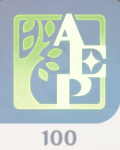

tenacity-of-the-millelith-flower-5


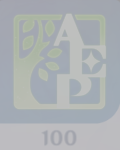

tenacity-of-the-millelith-circlet-5


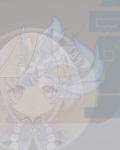

tenacity-of-the-millelith-circlet-5


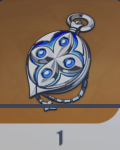

pale-flame-sands-5


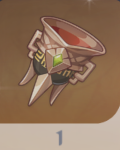

tenacity-of-the-millelith-goblet-5


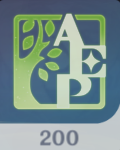

adventure-exp


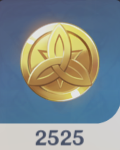

mora


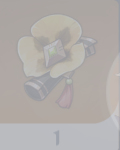

tenacity-of-the-millelith-circlet-5


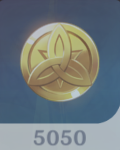

mora


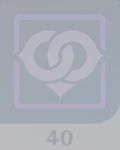

tenacity-of-the-millelith-circlet-5


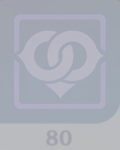

tenacity-of-the-millelith-circlet-5


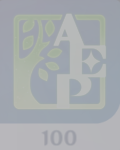

tenacity-of-the-millelith-circlet-5


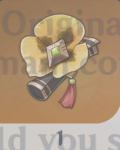

tenacity-of-the-millelith-flower-5


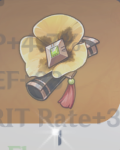

tenacity-of-the-millelith-flower-5


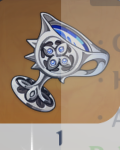

pale-flame-goblet-5


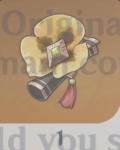

tenacity-of-the-millelith-flower-5


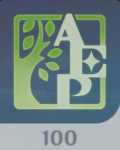

adventure-exp


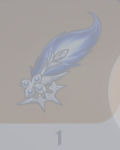

tenacity-of-the-millelith-circlet-5


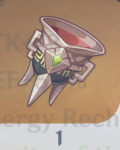

tenacity-of-the-millelith-sands-5


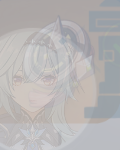

tenacity-of-the-millelith-circlet-5


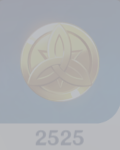

tenacity-of-the-millelith-circlet-5


In [28]:
y_guess = cnn_models[0].predict(X_test)
for i in range(X_test.shape[0]):
  display(Image.fromarray(X_test[i]))
  print(item_codes[np.argmax(y_guess[i])])

Save weights locally

In [29]:
cnn_models[0].save('model-1')

INFO:tensorflow:Assets written to: model-1/assets


In [31]:
from google.colab import files
files.download('model-1') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>